# Кафе
Перед открытием нового кафе в Москве необходимо подготовить исследование рынка, чтобы оценить вероятность успеха и определиться с форматом заведения.

В нашем распоряжении имееются открытые данные о заведениях общественного питания в Москве:

Таблица **data**:

* id — идентификатор объекта
* object_name — название объекта общественного питания
* chain — сетевой ресторан
* object_type — тип объекта общественного питания
* address — адрес
* number — количество посадочных мест

---



In [22]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats as st
import string
import requests
import re
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None

In [23]:
df = pd.read_csv('data.csv')


In [27]:
df.columns

Index(['id', 'object_name', 'chain', 'object_type', 'address', 'number'], dtype='object')

In [28]:
display(df.sample(10))
display(df.info())
display(df['number'].describe())
print('Дубликатов:', df.duplicated().sum())
display(df['chain'].unique())
display(df['object_type'].unique())

,id,object_name,chain,object_type,address,number
10184,203090,Бол бол фуд,нет,кафе,"город Москва, Щёлковское шоссе, дом 45А",40
10796,220564,Пивной бар,нет,бар,"город Москва, Нагатинская улица, дом 13, корпус 1",0
1411,52542,Перец и Мята,нет,кафе,"город Москва, улица Академика Пилюгина, дом 4",40
11120,210578,PHO вкусный,нет,кафе,"город Москва, Театральный проезд, дом 5, строе...",12
1387,25766,Пицца Пипони,да,предприятие быстрого обслуживания,"город Москва, шоссе Энтузиастов, дом 53",45
1195,136977,Чайная «Алхимик»,нет,закусочная,"город Москва, Октябрьская улица, дом 36",50
11415,219714,Хочу шашлык,нет,кафе,"город Москва, Митинская улица, дом 55, корпус 1",0
12741,257435,Донер Кебаб,нет,закусочная,"город Москва, Сокольническая площадь, дом 9",0
7920,170407,Чайхана,нет,кафе,"город Москва, Комсомольская площадь, дом 6, со...",47
7811,169491,Бургер Кинг,да,кафе,"город Москва, улица Барклая, дом 10А",21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16483 entries, 0 to 16482
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           16483 non-null  int64 
 1   object_name  16483 non-null  object
 2   chain        16483 non-null  object
 3   object_type  16483 non-null  object
 4   address      16483 non-null  object
 5   number       16483 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 772.8+ KB


None

count    16483.000000
mean        53.518170
std         72.346708
min          0.000000
25%         10.000000
50%         32.000000
75%         70.000000
max       1700.000000
Name: number, dtype: float64

Дубликатов: 0


array(['нет', 'да'], dtype=object)

array(['кафе', 'кафетерий', 'столовая',
       'предприятие быстрого обслуживания', 'ресторан', 'буфет', 'бар',
       'закусочная', 'магазин (отдел кулинарии)'], dtype=object)

In [29]:
print('Проверим корректность типов объектов:\n{}'.format(df['object_type'].value_counts()))

Проверим корректность типов объектов:
кафе                                 6513
столовая                             2392
ресторан                             2310
предприятие быстрого обслуживания    2246
бар                                  1043
кафетерий                             624
буфет                                 535
закусочная                            438
магазин (отдел кулинарии)             382
Name: object_type, dtype: int64


* В нашем распоряжении данные о 16483 заведениях Москвы.
* Полных дубликатов нет, однако, стоит поискать повторы, исключив id.
* Пропущенных значений нет.
* Тип поля chain можно заменить на boolean.
* Нужно выделить улицу в отдельный столбец для дальнейшего анализа.

# 2. Предобработка данных

In [30]:
# Обработаем поле с названием заведений:

df['object_name'] = df['object_name'].str.lower()
df['object_name'] = df['object_name'].str.strip()

In [31]:
# Поищем повторы:

rest_duplicated = df.groupby(['object_name','address','number','object_type', 'chain']).agg(count=('id','count'))
display(rest_duplicated.query('count > 1')) # 73 записи, но это могут быть ТЦ с несколькими однотипными заведениями

count
object_name      address                                            number object_type                       chain       
lift             город Москва, Багратионовский проезд, дом 7, ко... 3      кафе                              нет        2
                                                                    10     кафе                              нет        3
                                                                    20     кафе                              нет        3
one price coffee город Москва, Кировоградская улица, дом 13А        2      предприятие быстрого обслуживания нет        3
piccolo          город Москва, Дмитровское шоссе, дом 163А, корп... 0      предприятие быстрого обслуживания нет        2
...                                                                                                                   ...
шаурма           город Москва, улица Гарибальди, дом 23/54          0      предприятие быстрого обслуживания нет        2
                 город Москва, улица Грузинский Вал, дом 27         0      предприятие быстрого обслуживания нет        3
                 город Москва, улица Народного Ополчения, дом 22... 0      предприятие быстрого обслуживания нет        2
                 город Москва, улица Яблочкова, дом 21В, строение 1 0      предприятие быстрого обслуживания нет        2
экспресс кафе    город Москва, улица Земляной Вал, дом 29, строе... 3      кафе                              нет        2

[73 rows x 1 columns]

* Мы не можем быть абсолютно уверены, что получившиеся повторы действительно дубли - вполне вероятно, что по адресу находится ТЦ, в котором может быть несколько объектов, записанных как "каменев василий владимирович" или просто "кафе".

Вывод: дубли удалять не будем (благо их всего 73).

In [32]:
# Вынесем улицу в отдельный столбец.

# Унифицируем адресную строку, чтобы проще было выделить улицу - добавим к строкам без города "город Москва, ":
df['address'] = df['address'].apply(lambda x: 'город Москва, ' + str(x) if x.find('город') == -1 else x)

# Список типов улиц:
street_types = ['улица','ул','переулок','шоссе','проспект','площадь','проезд', 'село','аллея','бульвар','набережная','тупик','линия']
# Регулярное выражение выделяет подстроку между запятыми, содержащую тип улицы из нашего справочника:
str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(street_types))

df["street"] = df["address"].str.extract(str_pat, flags=re.I)

display(df.sample(10))

,id,object_name,chain,object_type,address,number,street
16245,271098,coffee moose,да,кафетерий,"город Москва, Большая Семёновская улица, дом 21",6,Большая Семёновская улица
6765,93644,ресторан «viet cafe»,нет,ресторан,"город Москва, Пресненская набережная, дом 2",30,Пресненская набережная
6373,152058,кафе ( закрытое),нет,кафе,"город Москва, улица Крымский Вал, дом 9, строе...",22,улица Крымский Вал
5193,23829,столовая структурного подразделения №1 гбоу шк...,нет,столовая,"город Москва, Большая Очаковская улица, дом 42...",250,Большая Очаковская улица
8722,180672,шаверма doner master,нет,предприятие быстрого обслуживания,"город Москва, Шипиловская улица, дом 53, корпус 2",0,Шипиловская улица
3745,26333,ресторан банкетного обслуживания,нет,ресторан,"город Москва, Кутузовский проспект, дом 2/1, с...",200,Кутузовский проспект
6860,136380,гбоу школа №2057 шо-1,нет,буфет,"город Москва, поселение Марушкинское, деревня ...",160,улица Липовая Аллея
2759,81578,кувера,нет,столовая,"город Москва, Новосущёвская улица, дом 26А",75,Новосущёвская улица
2453,19941,кафе «якитория»,да,кафе,"город Москва, улица Коштоянца, дом 2, корпус 1",101,улица Коштоянца
5000,27272,акира,нет,ресторан,"город Москва, Венёвская улица, дом 4",86,Венёвская улица


In [33]:
# Посмотрим, есть ли записи без улиц:

display(df[df['street'].isna()]) # 387

,id,object_name,chain,object_type,address,number,street
323,150654,love,нет,кафе,"город Москва, 2-й квартал Капотня, дом 1",40,NaN
1176,68113,френдс,нет,кафе,"город Москва, город Зеленоград, корпус 435",34,NaN
1177,20105,граф монте-кристо,нет,кафе,"город Москва, город Зеленоград, корпус 436",40,NaN
1178,151267,альфорно,нет,кафе,"город Москва, город Зеленоград, корпус 438",45,NaN
1179,150537,вечный зов,нет,кафе,"город Москва, город Зеленоград, корпус 834А",30,NaN
...,...,...,...,...,...,...,...
16232,271854,fabula,нет,бар,"город Москва, город Московский, 1-й микрорайон...",15,NaN
16288,263090,суши вок,да,предприятие быстрого обслуживания,"город Москва, микрорайон Северное Чертаново, к...",0,NaN
16315,248729,крошка картошка,да,предприятие быстрого обслуживания,"город Москва, поселение Московский, МКАД, 47-й...",0,NaN
16322,262446,пицца экспресс,да,кафе,"город Москва, поселение Вороновское, квартал №...",30,NaN


* 387 записей получились без улицы. Что ж, не все адреса содержат улицу.

In [34]:
# Приведём поле 'chain' к логическому типу данных:

df['chain'] = df['chain'].map({'да': True, 'нет': False})
display(df.head(5))
print(df.info())

,id,object_name,chain,object_type,address,number,street
0,151635,сметана,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,кафе «академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,119365,cotto итальянская кофейня,False,кафетерий,"город Москва, Абрамцевская улица, дом 9, корпус 1",40,Абрамцевская улица
4,27429,гбоу «школа № 1430 имени героя социалистическо...,False,столовая,"город Москва, Угличская улица, дом 17",240,Угличская улица


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16483 entries, 0 to 16482
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           16483 non-null  int64 
 1   object_name  16483 non-null  object
 2   chain        16483 non-null  bool  
 3   object_type  16483 non-null  object
 4   address      16483 non-null  object
 5   number       16483 non-null  int64 
 6   street       16092 non-null  object
dtypes: bool(1), int64(2), object(4)
memory usage: 788.9+ KB
None


# 3. Исследовательский анализ данных 

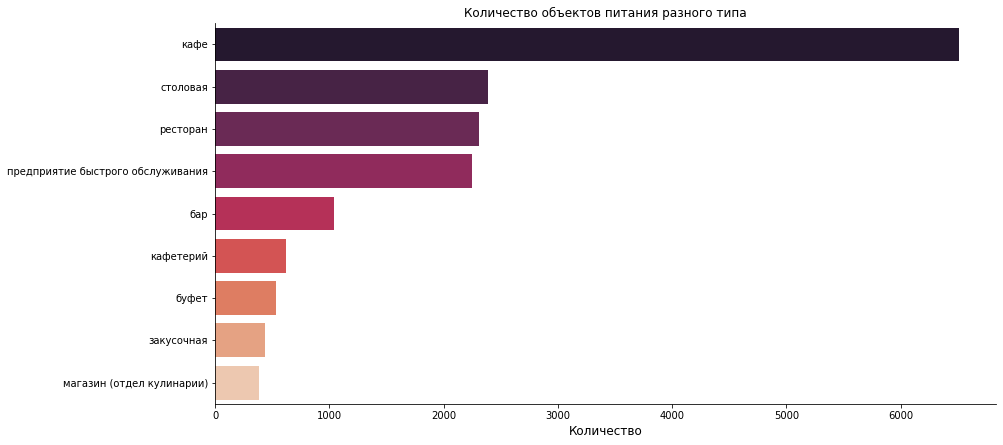

In [35]:
rest_by_type = df.groupby('object_type').agg(count = ('id','count')).reset_index().sort_values('count', ascending=False)

plt.figure(figsize=(14,7))
ax = sns.barplot(x='count', y='object_type', data=rest_by_type, palette="rocket", orient='h')
ax.set_title('Количество объектов питания разного типа')
ax.set_xlabel('Количество', fontsize = 12) 
ax.set_ylabel('')


sns.despine()
plt.show()

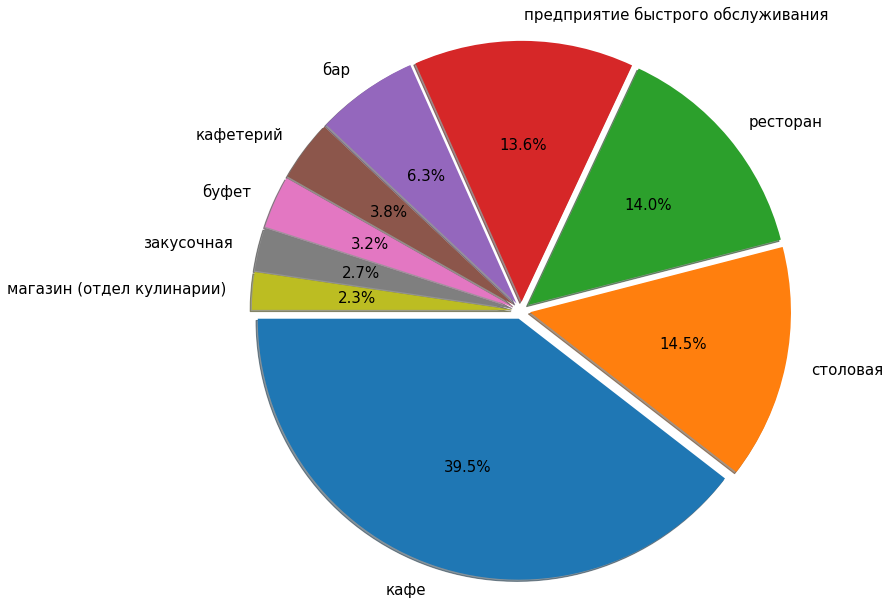

In [36]:
vals = rest_by_type['count']
labels = labels=rest_by_type['object_type']
explode = (0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
plt.pie(vals, labels=labels, explode = explode, autopct='%1.1f%%', shadow=True, radius = 3, startangle=180, textprops =textprops)
plt.show()

* Почти 40% объектов нашей базы относятся к типу "кафе"
* Следующие по численности столовые (14.5%), рестораны (14%) и предприятия быстрого обслуживания (13.6%)
* Значительно меньше баров (6.3%),кафетериев (3.8%), буфетов (3.2%), закусочных (2.7%) и кулинарий (2.3%)

**2.2. Cоотношение сетевых и несетевых заведений**

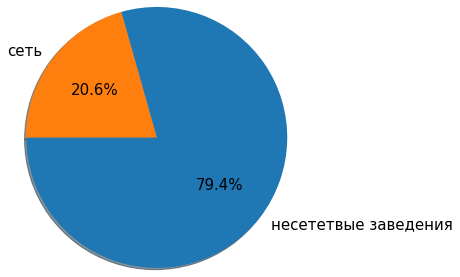

In [37]:
rest_by_chain = df.groupby('chain').agg(count = ('id','count')).reset_index()

vals = rest_by_chain['count']
labels = rest_by_chain['chain']
textprops = {"fontsize":15}
plt.pie(vals, labels=labels.map({True: 'сеть', False: 'несететвые заведения'}), autopct='%1.1f%%', shadow=True, radius = 1.5, startangle=180, textprops =textprops)
plt.show()

* Более 3/4 заведений являются несетевыми
* Около 20.6% объектов базы относятся к сетевым

**2.3. Виды сетевых объектов**

In [38]:
rest_chain_gr = df[df['chain']].groupby('object_type').agg(count=('id','count')).reset_index()

# Добавим в таблицу информацию об общем количестве заведений каждого типа:
rest_chain_gr = rest_chain_gr.merge(rest_by_type, how='left', left_on='object_type', right_on='object_type')
rest_chain_gr.columns = ['object_type', 'chain_count', 'total_count']

# Посчитаем долю сетевых заведений каждого типа:
rest_chain_gr['chain_prc'] = round((rest_chain_gr['chain_count'] / rest_chain_gr['total_count']) * 100, 2)
rest_chain_gr.sort_values('total_count', ascending=False, inplace=True)

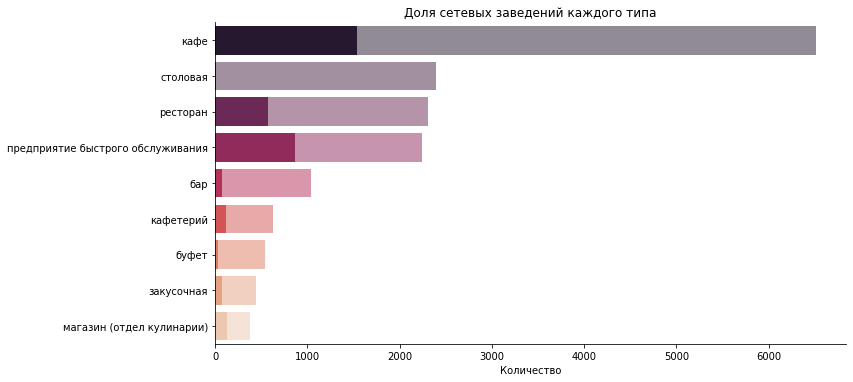

,object_type,chain_count,total_count,chain_prc
6,предприятие быстрого обслуживания,866,2246,38.56
5,магазин (отдел кулинарии),132,382,34.55
7,ресторан,569,2310,24.63
3,кафе,1541,6513,23.66
4,кафетерий,113,624,18.11
2,закусочная,75,438,17.12
0,бар,69,1043,6.62
1,буфет,26,535,4.86
8,столовая,7,2392,0.29


In [39]:
g = sns.catplot(data=rest_chain_gr, kind="bar", x="chain_count", y="object_type", palette="rocket", alpha=1,  height=5, aspect=12/5, orient='h')
ax = sns.barplot(x='total_count', y='object_type', data=rest_chain_gr, palette="rocket", alpha=.5,  orient='h')
g.set_axis_labels("Количество", "")
plt.title("Доля сетевых заведений каждого типа")
plt.show()

display(rest_chain_gr.sort_values('chain_prc', ascending=False))

* Самая большая доля сетевых объектов приходится на предприятия быстрого обслуживания - 38.5% от общего числа заведений этого типа
* Далее по содержанию сетевых заведений в общем количестве объектов данного типа следуют отделы кулинарии (~34.5%), рестораны (24.6%) и кафе (23.6%)
* При этом, по абсолютному количеству среди сетей лидируют кафе (1541 точка)

**2.4. Сетевые заведения общественного питания**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



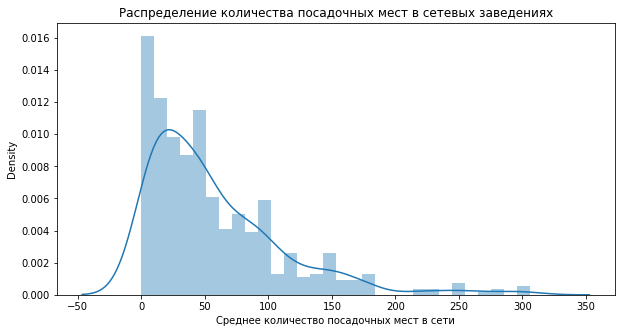

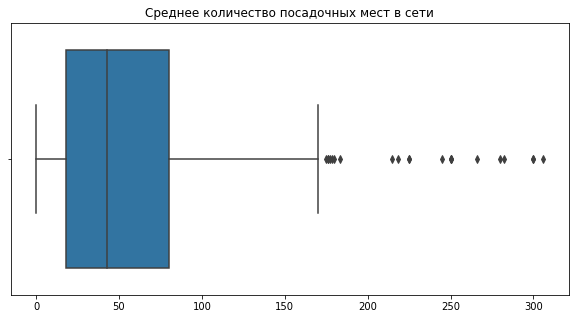

In [40]:
rest_chain = df[df['chain']].groupby(['object_name']).agg(count=('id','count'), number_mean=('number', 'mean'))
rest_chain.sort_values('count', ascending=False, inplace=True)
#display(rest_chain.head())

plt.figure(figsize=(10, 5))
plt.title('Распределение количества посадочных мест в сетевых заведениях')
sns.distplot(rest_chain['number_mean'], bins=30) 
plt.xlabel('Среднее количество посадочных мест в сети')
plt.show()

plt.figure(figsize=(10, 5))
plt.title('Среднее количество посадочных мест в сети')
sns.boxplot(x="number_mean", data=rest_chain)
plt.xlabel('')
plt.show()

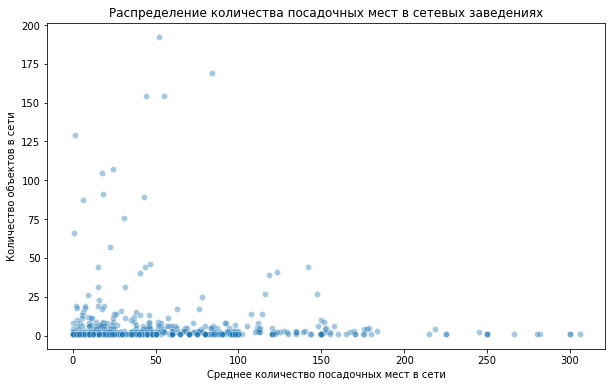

In [41]:
plt.figure(figsize=(10, 6))
#plt.ylim(0,5) # Можно посмотреть поближе в левый нижний угол
plt.title('Распределение количества посадочных мест в сетевых заведениях')
sns.scatterplot(x="number_mean", y="count",
                palette="ch:r=-.2,d=.3_r",
                alpha = 0.4,
                data=rest_chain)
plt.xlabel('Среднее количество посадочных мест в сети')
plt.ylabel('Количество объектов в сети')
plt.show()

* В нашей базе оказалось множество "сетей" состоящих из одного объекта. Разброс количества посадочных мест у них довольно большой. Однако, чаще всего мест немного

Посмотрим поближе на сети с количеством объектов более 2-х.

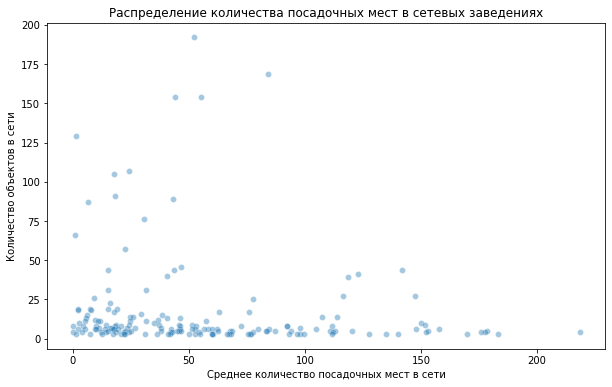

In [42]:
plt.figure(figsize=(10, 6))
#plt.ylim(0,5) # Можно посмотреть поближе в левый нижний угол
plt.title('Распределение количества посадочных мест в сетевых заведениях')
sns.scatterplot(x="number_mean", y="count",
                palette="ch:r=-.2,d=.3_r",
                alpha = 0.4,
                data=rest_chain[rest_chain['count'] > 2])
plt.xlabel('Среднее количество посадочных мест в сети')
plt.ylabel('Количество объектов в сети')
plt.show()


* Картина та же: основная масса сетей сконцентрирована в нижнем левом углу - небольшое количество объектов со средним количеством посадочных мест.
* Крупные сети, во-первых, редко встречаются, и во-вторых, редко имеют более 30-ти посадочных мест.

**2.5. Посадочные места в заведениях разного типа**

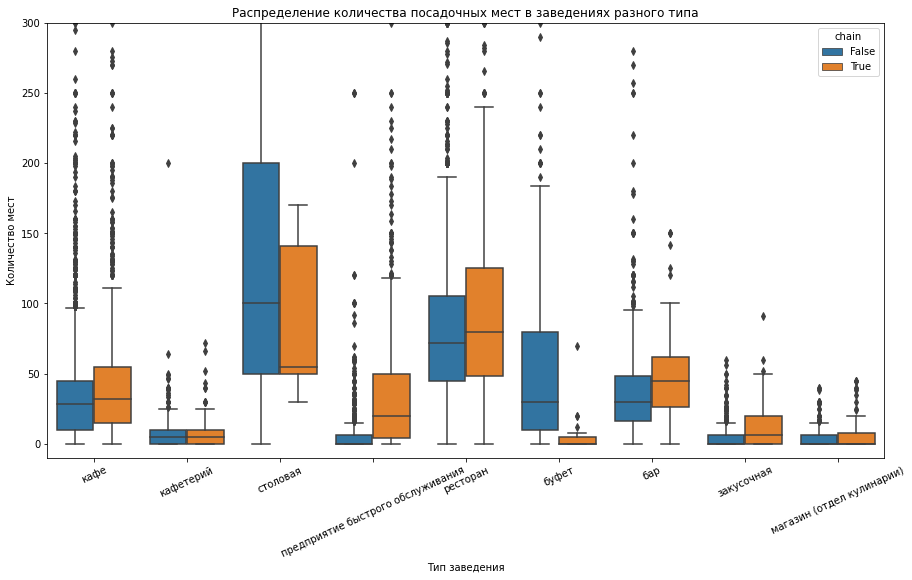

count  number_median
object_type                       chain                      
бар                               False    974             30
                                  True      69             45
буфет                             False    509             30
                                  True      26              0
закусочная                        False    363              0
                                  True      75              6
кафе                              False   4972             28
                                  True    1541             32
кафетерий                         True     113              5
                                  False    511              5
магазин (отдел кулинарии)         False    250              0
                                  True     132              0
предприятие быстрого обслуживания False   1380              0
                                  True     866             20
ресторан                          False   1741             72
                                  True     569             80
столовая                          False   2385            100
                                  True       7             55

In [43]:
plt.figure(figsize=(15, 8))
plt.ylim(-10,300)
plt.title('Распределение количества посадочных мест в заведениях разного типа')
sns.boxplot(x="object_type", y="number", hue="chain", data=df) 
plt.xlabel('Тип заведения')
plt.ylabel('Количество мест') 
plt.xticks(rotation=25)
plt.show()

display(df
        .groupby(['object_type', 'chain'])
        .agg(count=('id', 'count'), number_median=('number', 'median')) # Исп. медиану для оценки ср. числа посадочных мест
        .sort_values('object_type')
       )


Для оценки среднего значения посадочных мест будем использовать медиану, т.к. распределение этих значений отличается от нормального.

* Среднее значение посадочных мест в сетевых заведениях выше, чем в несетевых для всех типов объектов общественного питания, кроме столовых.

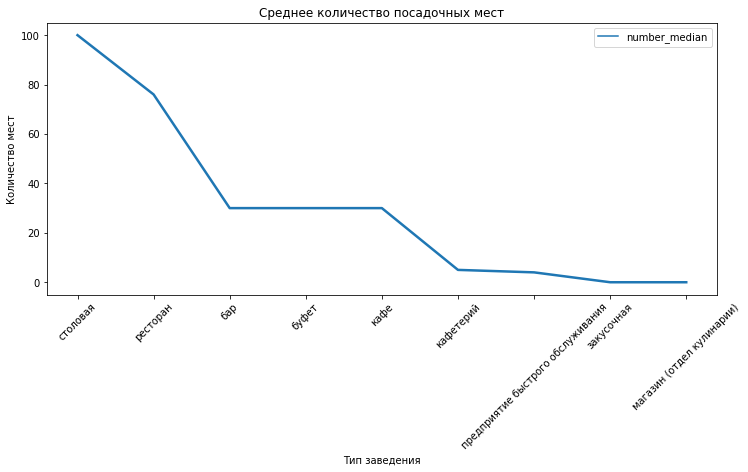

,number_median
object_type,
столовая,100
ресторан,76
бар,30
буфет,30
кафе,30
кафетерий,5
предприятие быстрого обслуживания,4
закусочная,0
магазин (отдел кулинарии),0


In [44]:
rest_number_median = (df
                      .groupby(['object_type'])
                      .agg(number_median=('number', 'median'))
                      .sort_values('number_median', ascending=False)
                     )
plt.figure(figsize=(12, 5))
plt.title('Среднее количество посадочных мест')
sns.lineplot(data=rest_number_median, palette="tab10", linewidth=2.5, sort=False)
plt.xlabel('Тип заведения')
plt.ylabel('Количество мест') 
plt.xticks(rotation=45)
plt.show()

display(rest_number_median)

In [45]:
fig = px.box(df, x='object_type', y='number', color='chain', title='Распределение количества посадочных мест в сетевых заведениях')
fig.update_xaxes(title='Тип заведения')
fig.update_yaxes(title='Количество мест')
fig.show()

* Самое большое количество посадочных мест в среднем предоставляют столовые (100) и рестораны (76)
* Далее по числу мест следуют бары (30), буфеты (30) и кафе (30)
* В среднем мало мест предоставляют кафетерии (5) и предприятия быстрого обслуживания (4)
* В закусочных и отделах кулинарии посадочных мест в среднем нет

**2.6. Топ-10 улиц по количеству объектов общественного питания**

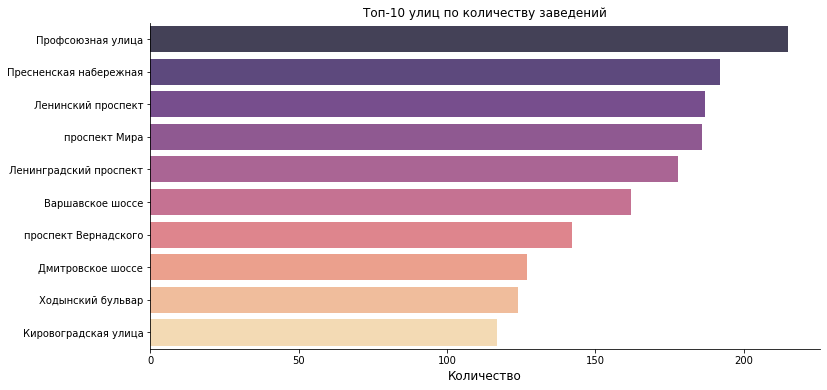

,street,count
0,Профсоюзная улица,215
1,Пресненская набережная,192
2,Ленинский проспект,187
3,проспект Мира,186
4,Ленинградский проспект,178
5,Варшавское шоссе,162
6,проспект Вернадского,142
7,Дмитровское шоссе,127
8,Ходынский бульвар,124
9,Кировоградская улица,117


In [46]:
rest_by_street = df.groupby('street').agg(count = ('id', 'count')).sort_values('count', ascending=False).reset_index()
rest_by_street_top10 = rest_by_street.head(10)

plt.figure(figsize=(12,6))
ax = sns.barplot(x='count', y='street', data=rest_by_street_top10, palette='magma', alpha=.8, orient='h')
ax.set_title('Топ-10 улиц по количеству заведений')
ax.set_xlabel('Количество', fontsize = 12) 
ax.set_ylabel('') 
sns.despine()
plt.show()

display(rest_by_street_top10)

Определим районы Москвы, в которых находятся эти улицы. Для этого воспользуемся внешним источником, например, файлом с данными Мосгаза.

In [49]:
#districts = pd.read_csv('http://hubofdata.ru/storage/f/2013-10-22T09%3A25%3A27.793Z/mosgaz-streets.csv')
districts = pd.read_csv('mosgaz-streets.csv')
display(districts.head(10))

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район
5,Малый Гнездниковский переулок,17,ЦАО,Пресненский район
6,Большая Грузинская улица,17,ЦАО,Пресненский район
7,Малая Грузинская улица,17,ЦАО,Пресненский район
8,Грузинская площадь,17,ЦАО,Пресненский район
9,улица Грузинский Вал,17,ЦАО,Пресненский район


In [50]:
rest_by_street = rest_by_street.merge(districts, how='left', left_on='street', right_on='streetname')
rest_by_street = rest_by_street.drop(['streetname', 'areaid'], axis=1)

rest_by_street_top10 = rest_by_street_top10.merge(districts, how='left', left_on='street', right_on='streetname')
rest_by_street_top10 = rest_by_street_top10.drop(['streetname', 'areaid'], axis=1)

In [51]:
display(rest_by_street_top10)

,street,count,okrug,area
0,Профсоюзная улица,215,ЮЗАО,Академический район
1,Профсоюзная улица,215,ЮЗАО,Район Черемушки
2,Профсоюзная улица,215,ЮЗАО,Район Ясенево
3,Профсоюзная улица,215,ЮЗАО,Район Коньково
4,Профсоюзная улица,215,ЮЗАО,Обручевский район
5,Профсоюзная улица,215,ЮЗАО,Район Теплый Стан
6,Пресненская набережная,192,ЦАО,Пресненский район
7,Ленинский проспект,187,ЗАО,Район Проспект Вернадского
8,Ленинский проспект,187,ЗАО,Район Тропарево-Никулино
9,Ленинский проспект,187,ЮАО,Донской район


В Топ-10 попали самые длинные улицы Москвы, проходящие сразу через несколько районов, а порой и округов. Не удивительно, что в сумме на этих улицах больше всего заведений общественного питания.

In [57]:
# Посмотрим, через какие округа проходят самые богатые на общепит улицы:
okrug_top10 = pd.DataFrame(rest_by_street_top10.groupby('okrug')['street'].nunique().reset_index())

# Все возможные округа:
okrug_total = pd.DataFrame(districts.groupby('okrug')['streetname'].count().reset_index())

# Все районы по округам:
district_total = pd.DataFrame(districts.groupby(['okrug', 'area'])['streetname'].count().reset_index())

# Соберём вместе для наглядности:
rep_okrug_top10 = okrug_top10.merge(okrug_total, how='right', left_on='okrug', right_on='okrug')
rep_okrug_top10 = rep_okrug_top10.drop(['streetname'], axis=1)
rep_okrug_top10['street'] = rep_okrug_top10['street'].fillna(0).astype('int32')
rep_okrug_top10.sort_values('street', ascending=False, inplace=True)

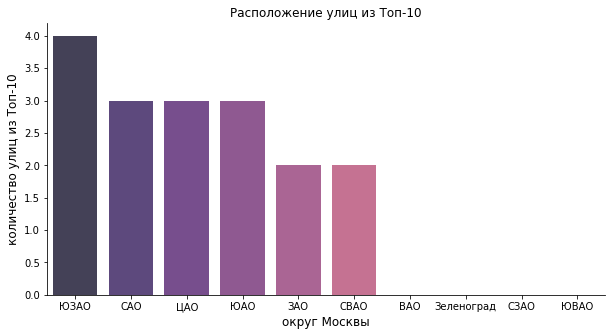

,okrug,street
9,ЮЗАО,4
3,САО,3
6,ЦАО,3
7,ЮАО,3
1,ЗАО,2
4,СВАО,2
0,ВАО,0
2,Зеленоград,0
5,СЗАО,0
8,ЮВАО,0


In [58]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='okrug', y='street', data=rep_okrug_top10, palette="magma", alpha=.8)
ax.set_title('Расположение улиц из Топ-10')
ax.set_xlabel('округ Москвы', fontsize = 12) 
ax.set_ylabel('количество улиц из Топ-10', fontsize = 12) 
sns.despine()
plt.show()

display(rep_okrug_top10)

Самые богатые на общепит улицы находятся преимущественно на юге Москвы, некоторые дотягиваются и до центра.


**2.7. Улицы с одним объектом общественного питания**

In [59]:

one_rest_streets = rest_by_street[rest_by_street['count'] == 1]
one_rest_streets.sort_values(['count','street'], ascending=['True', 'False'], inplace=True)

display(one_rest_streets.sample(5))

,street,count,okrug,area
2373,Малый Саввинский переулок,1,ЦАО,Район Хамовники
2048,Большой Николопесковский переулок,1,ЦАО,Район Арбат
1881,Калашный переулок,1,ЦАО,Пресненский район
2138,Фруктовая улица,1,ЮАО,Нагорный район
1995,Икшинская улица,1,САО,Дмитровский район


In [60]:
# Посмотрим, через какие округа проходят самые обделённые общепитом улицы:
okrug_one_rest = pd.DataFrame(one_rest_streets.groupby('okrug')['street'].nunique().reset_index()) 

# Добавим для наглядности остальные округа:
rep_okrug_one_rest = okrug_one_rest.merge(okrug_total, how='right', left_on='okrug', right_on='okrug')
rep_okrug_one_rest = rep_okrug_one_rest.drop(['streetname'], axis=1)
#okrug_one_rest['street'] = okrug_one_rest['street'].fillna(0).astype('int32')
rep_okrug_one_rest.sort_values('street', ascending=False, inplace=True)

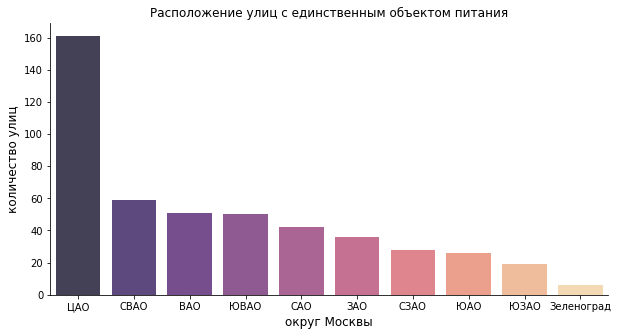

,okrug,street,prc
6,ЦАО,161,33.68
4,СВАО,59,12.34
0,ВАО,51,10.67
8,ЮВАО,50,10.46
3,САО,42,8.79
1,ЗАО,36,7.53
5,СЗАО,28,5.86
7,ЮАО,26,5.44
9,ЮЗАО,19,3.97
2,Зеленоград,6,1.26


In [61]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='okrug', y='street', data=rep_okrug_one_rest, palette="magma", alpha=.8)
ax.set_title('Расположение улиц с единственным объектом питания')
ax.set_xlabel('округ Москвы', fontsize = 12) 
ax.set_ylabel('количество улиц', fontsize = 12) 
sns.despine()
plt.show()

rep_okrug_one_rest['prc'] = round((rep_okrug_one_rest['street'] / rep_okrug_one_rest['street'].sum()) * 100, 2)
rep_okrug_one_rest

In [62]:
# Районы, через которые проходят улицы с единственным объектом:
district_one_rest = pd.DataFrame(one_rest_streets.groupby('area')['street'].nunique().reset_index()) 
district_one_rest.sort_values('street', ascending=False, inplace=True)

# Добавим для наглядности округа:
rep_district_one_rest = district_one_rest.merge(district_total, how='left', left_on='area', right_on='area')
rep_district_one_rest = rep_district_one_rest.drop(['streetname'], axis=1)

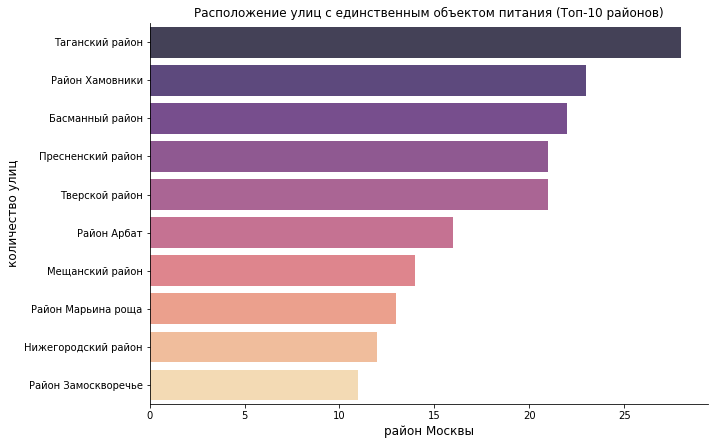

,area,street,okrug
0,Таганский район,28,ЦАО
1,Район Хамовники,23,ЦАО
2,Басманный район,22,ЦАО
3,Пресненский район,21,ЦАО
4,Тверской район,21,ЦАО
5,Район Арбат,16,ЦАО
6,Мещанский район,14,ЦАО
7,Район Марьина роща,13,СВАО
8,Нижегородский район,12,ЮВАО
9,Район Замоскворечье,11,ЦАО


Количество улиц с единственным объектом общественного питания: 550


In [63]:
plt.figure(figsize=(10, 7))
ax = sns.barplot(x='street', y='area', data=rep_district_one_rest.head(10), palette="magma", alpha=.8, orient='h')
ax.set_title('Расположение улиц с единственным объектом питания (Топ-10 районов)')
ax.set_xlabel('район Москвы', fontsize = 12) 
ax.set_ylabel('количество улиц', fontsize = 12) 
sns.despine()
plt.show()

display(rep_district_one_rest.head(10))
print('\033[1m'+'Количество улиц с единственным объектом общественного питания:', one_rest_streets['count'].sum())


Количество улиц с единственным объектом общественного питания: 596
* Всего в базе 596 улиц с единственным объектом питания
* Самое большое количество улиц с одним заведением находится в центральных районах города: Таганском, Хамовниках, Басманном, Тверском, Пресненском и др.
* Кроме того, почти треть всех улиц с одним объектом находится в центре Москвы
* Следом идут северные и восточные направления (СВАО, ЮВАО, САО)

**2.8. Распределение количества посадочных мест для улиц из Топ-10**

In [65]:
top10_rest = df[df['street'].isin(rest_by_street_top10['street'].unique())]
#top10_rest # 1630 записей

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



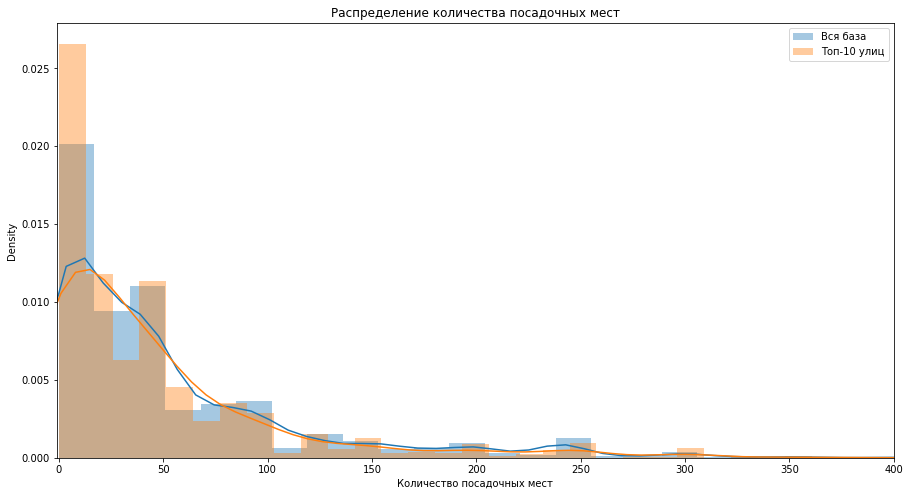

In [66]:
plt.figure(figsize=(15, 8))
plt.xlim(-1,400)
plt.title('Распределение количества посадочных мест')
sns.distplot(df[~df['street'].isin(rest_by_street_top10['street'].unique())]['number'], bins=100, label='Вся база') 
sns.distplot(top10_rest['number'], bins=100, label='Топ-10 улиц') 
plt.xlabel('Количество посадочных мест')
plt.legend()
plt.show()

* Распределения количества посадочных мест на улицах из Топ-10 и по всей остальной базе практически совпадают

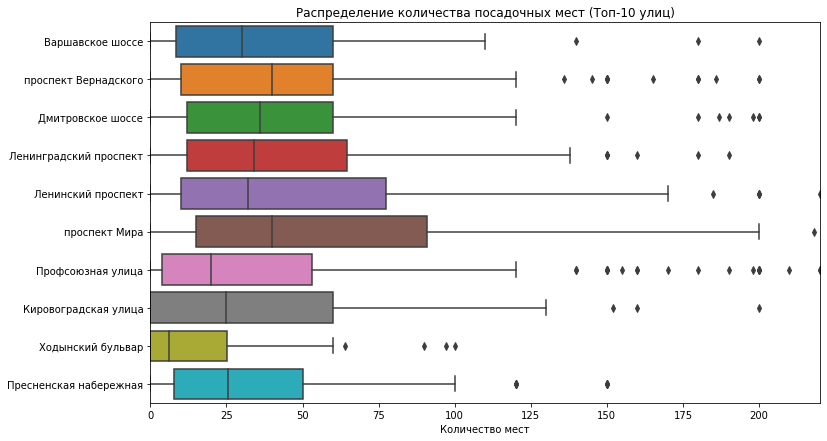

In [67]:
plt.figure(figsize=(12, 7))
plt.xlim(0,220)
plt.title('Распределение количества посадочных мест (Топ-10 улиц)')
#sns.scatterplot(x="street", y="number", data=top10_rest) 
sns.boxplot(x="number", y="street", data=top10_rest, orient='h') 
plt.xlabel('Количество мест')
plt.ylabel('') 
plt.show()

* Тенденции по Топ-10 совпадают со всей базой в целом: большинство заведений предоставляют не более 50 посадочных мест, более 100 мест встречаются крайне редко.

Проверим гипотезу о равенстве среднего количества посадочных мест на улицах из Топ-10 и остальных улицах базы, т.е. о равенстве двух независимых выборок. Т.к. распределения средних значений отличаются от нормального и они не зависят между собой, воспользуемся критерием Манна-Уитни:

In [72]:
top10_number = top10_rest['number'].values

df_number = df[~df['street'].isin(rest_by_street_top10['street'].unique())]['number'].values

alpha = .05 # критический уровень статистической значимости

results = st.mannwhitneyu(top10_number, df_number)

print('\033[1mНулевая гипотеза H0: между выборками нет разницы\033[0m')
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Нулевая гипотеза H0: между выборками нет разницы
p-значение:  4.492919660515016e-06
Отвергаем нулевую гипотезу


Итак, у нас есть все основания считать, что среднее количество посадочных мест в заведениях общепита на улицах из Топ-10 отличается от среднего количества мест по остальной базе

# 4. Общий вывод


**Виды объектов общественного питания:**

* Почти 40% объектов нашей базы относятся к типу "кафе"
* Следующие по численности столовые (14.5%), рестораны (14%) и предприятия быстрого обслуживания (13.6%)
* Значительно меньше баров (6.3%),кафетериев (3.8%), буфетов (3.2%), закусочных (2.7%) и кулинарий (2.3%)

**Сетевые заведения:**

* Более 3/4 заведений являются несетевыми
* Около 20.6% объектов базы относятся к сетевым
* Самая большая доля сетевых объектов приходится на предприятия быстрого обслуживания - 38.5% от общего числа заведений этого типа
* Далее по содержанию сетевых заведений в общем количестве объектов данного типа следуют отделы кулинарии (~34.5%), рестораны (24.6%) и кафе (23.6%)
* При этом, по абсолютному количеству среди сетей лидируют кафе (1541 точка)

**Посадочные места:**

* Самое большое количество посадочных мест в среднем предоставляют столовые (100) и рестораны (76)
* Далее по числу мест следуют бары (30), буфеты (30) и кафе (30)
* В среднем мало мест предоставляют кафетерии (5) и предприятия быстрого обслуживания (4)
* В закусочных и отделах кулинарии посадочных мест в среднем нет
* Среднее значение посадочных мест в сетевых заведениях выше, чем в несетевых для всех типов объектов общественного питания, кроме столовых.
* Основная масса сетей состоит из небольшого количества объектов со средним количеством посадочных мест (20-30)
* Крупные сети, во-первых, редко встречаются, и во-вторых, редко имеют более 30-ти посадочных мест

**Расположение объектов общественного питания:**

* Самые богатые на общепит улицы проходят сразу через несколько районов, а порой и округов Москвы, и располагаются преимущественно на юге и западе, и в ценре города
* Всего в базе 596 улиц с единственным объектом питания
* Самое большое количество улиц с одним заведением находится в центральных районах города: Таганском, Хамовниках, Басманном, Тверском, Пресненском и др.
* Кроме того, почти треть всех улиц с одним объектом находится в центре Москвы
* Следом идут северные и восточные направления (СВАО, ЮВАО, САО)

**Посадочные места в заведениях на "популярных" улицах:**

* Тенденции по Топ-10 совпадают со всей базой в целом: большинство заведений предоставляют не более 50 посадочных мест, более 100 мест встречаются крайне редко.

В ходе исследования мы подтвердили, что небольшое кафе - это довольно перспективный вариант заведения общественного питания. Также нам удалось установить оптимальное количество посадочных мест - 30-40 - и наиболее популярные с точки зрения общепита районы Москвы - ЮАО, ЮЗАО, ЗАО. Практика конкурентов показывает, что такой формат заведений масштабируется чаще, чем, например, предприятия быстрого обслуживания или рестораны, т.е. доказана возможность развития сети.